<a href="https://colab.research.google.com/github/vishalrk1/pytorch/blob/main/Inception_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

import torchvision
from torchvision import transforms, models, datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Inception block

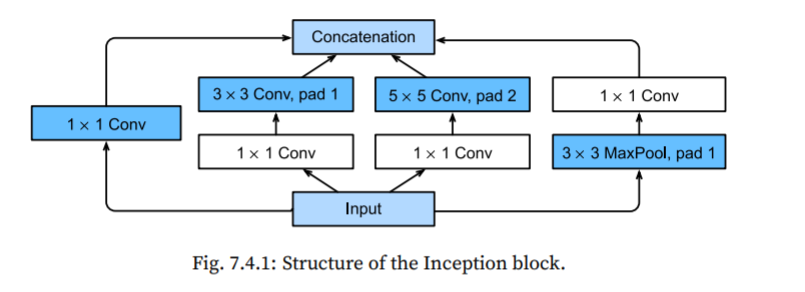

In [19]:
class Inception(nn.Module):
  '''
  c1 to c4 are the number of output channels for each path
  c2, c3 ==> (C1, C2)
  '''
  def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
    super(Inception, self).__init__(**kwargs)
    # path 1 1x1 Convolutional layer
    self.p1_1 = nn.Conv2d(in_channels=in_channels, out_channels=c1, kernel_size=1)
    # path 2 is 1x1 convolutional followed by a 3x3
    self.p2_1 = nn.Conv2d(in_channels=in_channels, out_channels=c2[0], kernel_size=1)
    self.p2_2 = nn.Conv2d(in_channels=c2[0], out_channels=c2[1], kernel_size=3, padding=1)
    # path 3 is 1x1 convolutional followed by 5x5 convolutional layer
    self.p3_1 = nn.Conv2d(in_channels=in_channels, out_channels=c3[0], kernel_size=1)
    self.p3_2 = nn.Conv2d(in_channels=c3[0], out_channels=c3[1], kernel_size=5, padding=2)
    # path 4 is 3x3 max pool layer followed by 1x1 convolutional layer
    self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    self.p4_2 = nn.Conv2d(in_channels=in_channels, out_channels=c4, kernel_size=1)
  
  def forward(self, x):
    p1 = F.relu(self.p1_1(x))
    # path 2
    p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
    # path 3
    p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
    # path 4
    p4 = F.relu(self.p4_2(self.p4_1(x)))
    # concatinating all pathe
    return torch.cat((p1, p2, p3, p4), dim=1)

## GoogleNet Model
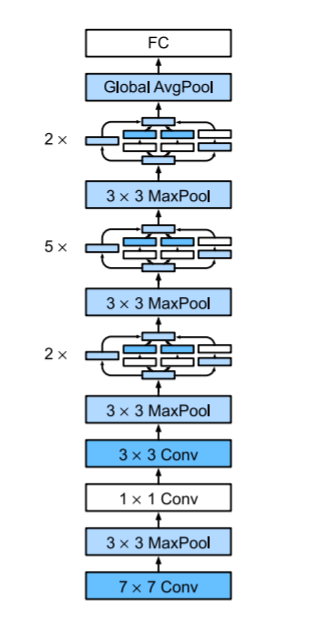

In [20]:
b1 = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

b2 = nn.Sequential(
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)

b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)

b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),  
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)

b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
)

In [21]:
model = nn.Sequential(
    b1,
    b2,
    b3,
    b4,
    b5,
    nn.Linear(1024, 2),
)

model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Inception(
      (p1_1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (p2_1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (p2_2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (p3_1): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (p3_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (p4_1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (p4_2): Conv2d(192, 32, ker

In [22]:
!pip install torchinfo

In [23]:
from torchinfo import summary
summary(model, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Sequential: 1-1                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,472
│    └─ReLU: 2-2                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-3                    [1, 64, 56, 56]           --
├─Sequential: 1-2                        [1, 192, 28, 28]          --
│    └─Conv2d: 2-4                       [1, 64, 56, 56]           4,160
│    └─ReLU: 2-5                         [1, 64, 56, 56]           --
│    └─Conv2d: 2-6                       [1, 192, 56, 56]          110,784
│    └─ReLU: 2-7                         [1, 192, 56, 56]          --
│    └─MaxPool2d: 2-8                    [1, 192, 28, 28]          --
├─Sequential: 1-3                        [1, 480, 14, 14]          --
│    └─Inception: 2-9                    [1, 256, 28, 28]          --
│   

## Importing data & preparing for training 

In [24]:
# Dataset 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# importing helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, pred_and_plot, unzip_data, walk_through_dir

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

unzip_data('pizza_steak.zip')

--2022-01-18 08:07:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-18 08:07:02 (48.5 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]

--2022-01-18 08:07:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 

In [25]:
train_dir = '/content/pizza_steak/train'
test_dir = '/content/pizza_steak/test'

In [26]:
num_workers = 4

BATCH_SIZE = 32

valid_size = 0.2

normalize = transforms.Normalize(
    [0.485, 0.456, 0.406], 
    [0.229, 0.224, 0.225]
)

train_transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    normalize,
])

test_transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# choose the training and test datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=num_workers)
valid_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=valid_sampler, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [27]:
classes = train_data.classes
class_len = len(classes)

classes

['pizza', 'steak']

## Training Model

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [29]:
# Model training

epochs = 10

min_valid_loss = 0

results = {
    'train_losses': [],
    'valid_losses': [],
    'train_acc': [],
    'valid_acc': [],
}

for epoch in range(epochs):
  print(f'<----- Epoch: {epoch+1} ----->')
  train_loss = 0
  valid_loss = 0

  train_acc = 0
  valid_acc = 0

  # training model on training dataset
  model.train()
  for images, labels in tqdm(train_dataloader, total=len(train_dataloader)):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()

    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    output_class = torch.softmax(output, dim=1).argmax(dim=1)
    train_acc += (output_class == labels).sum().item()/len(output)

  # evaluating model on validation dataset
  model.eval()
  for images, labels in tqdm(valid_dataloader, total=len(valid_dataloader)):
    images, labels = images.to(device), labels.to(device)

    output = model(images)
    loss = criterion(output, labels)

    valid_loss += loss.item()

    output_class = torch.softmax(output, dim=1).argmax(dim=1)
    valid_acc += (output_class == labels).sum().item()/len(output)

  # calculating losses
  train_loss = train_loss / len(train_dataloader)
  valid_loss = valid_loss / len(valid_dataloader)

  # calculating accuracy
  train_acc = train_acc / len(train_dataloader)
  valid_acc = valid_acc / len(valid_dataloader)

  # storing losses and accuracy
  results['train_losses'].append(train_loss)
  results['valid_losses'].append(valid_loss)
  results['train_acc'].append(train_acc)
  results['valid_acc'].append(valid_acc)

  if valid_loss <= min_valid_loss or min_valid_loss==0:
    print('Saving Model')
    torch.save(model.state_dict(), 'InceptionModel.pt')
    min_valid_loss = valid_loss

  print('Training Loss: {:.6f} \tTraining Accuracy: {:.2f}'.format(train_loss, train_acc))
  print('Validation Loss: {:.6f} \tValidation Accuracy: {:.2f}'.format(valid_loss, valid_acc))
  print('\n')

<----- Epoch: 1 ----->


  0%|          | 0/38 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/10 [00:00<?, ?it/s]

Saving Model
Training Loss: 0.694181 	Training Accuracy: 0.50
Validation Loss: 0.693031 	Validation Accuracy: 0.51


<----- Epoch: 2 ----->


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Saving Model
Training Loss: 0.688972 	Training Accuracy: 0.54
Validation Loss: 0.620043 	Validation Accuracy: 0.81


<----- Epoch: 3 ----->


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Saving Model
Training Loss: 0.611547 	Training Accuracy: 0.68
Validation Loss: 0.495696 	Validation Accuracy: 0.78


<----- Epoch: 4 ----->


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.561142 	Training Accuracy: 0.72
Validation Loss: 0.576284 	Validation Accuracy: 0.68


<----- Epoch: 5 ----->


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Saving Model
Training Loss: 0.569452 	Training Accuracy: 0.73
Validation Loss: 0.482963 	Validation Accuracy: 0.80


<----- Epoch: 6 ----->


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Saving Model
Training Loss: 0.501913 	Training Accuracy: 0.77
Validation Loss: 0.443679 	Validation Accuracy: 0.79


<----- Epoch: 7 ----->


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Saving Model
Training Loss: 0.474967 	Training Accuracy: 0.78
Validation Loss: 0.433596 	Validation Accuracy: 0.83


<----- Epoch: 8 ----->


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Saving Model
Training Loss: 0.465583 	Training Accuracy: 0.79
Validation Loss: 0.423796 	Validation Accuracy: 0.84


<----- Epoch: 9 ----->


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Saving Model
Training Loss: 0.442785 	Training Accuracy: 0.82
Validation Loss: 0.415321 	Validation Accuracy: 0.81


<----- Epoch: 10 ----->


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Saving Model
Training Loss: 0.457091 	Training Accuracy: 0.80
Validation Loss: 0.395524 	Validation Accuracy: 0.84




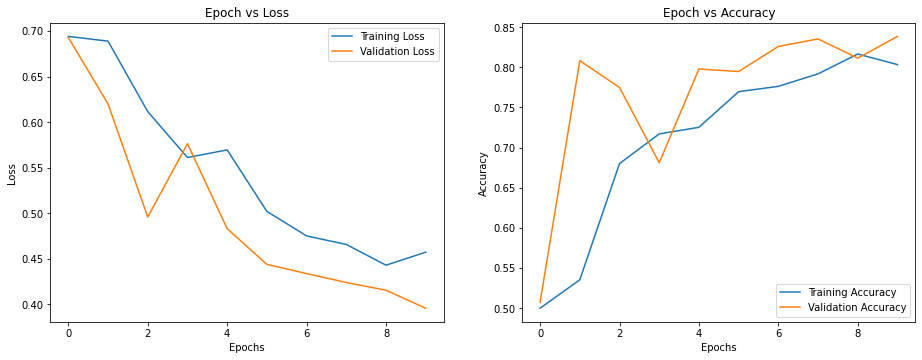

In [31]:
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  #plt.show()

plot_loss_accuracy(results['train_losses'], results['train_acc'], results['valid_losses'], results['valid_acc'])

In [35]:
model = torch.load('/content/InceptionModel.pt')

In [36]:
# calculating accuracy for test dataset
# function to calculate accuracy 
def calculate_acc(model, loader):
  n_correct = 0
  n_total = 0

  for inputs, targets in loader:
    # moving data to gpu
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Getting prediction
    # torch max returns both max and argmax
    _, preds = torch.max(outputs, 1)

    # Updating counts
    n_correct += (preds == targets).sum().item()
    n_total += targets.shape[0] 

  acc = n_correct / n_total
  return acc

calculate_acc(model, test_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TypeError: ignored